## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_num = [var for var in data.columns if data[var].dtypes != 'O']
vars_cat = [var for var in data.columns if data[var].dtypes=='O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [11]:
# find missing values in numerical variables 
num_vars_with_missing = [var for var in data[vars_num].columns if data[var].isnull().sum()>1]

# print the variable name and the percentage of missing values
for var in num_vars_with_missing:
    print(var, np.round(data[var].isnull().mean(), 3),  ' % missing values')



age 0.201  % missing values


In [12]:
# find missing values in categorical variables
cat_vars_with_missing = [var for var in data[vars_cat].columns if data[var].isnull().sum()>1]

# print the variable name and the percentage of missing values
for var in cat_vars_with_missing:
    print(var, np.round(data[var].isnull().mean(), 3),  ' % missing values')



cabin 0.775  % missing values
embarked 0.002  % missing values


### Determine cardinality of categorical variables

In [13]:
#how many categories are there in categorical variables 
for var in vars_cat:
    print(var, len(data[var].unique()), ' categories')
    #cabin has a lot of categories and a lot of missing values 

sex 2  categories
cabin 182  categories
embarked 4  categories
title 5  categories


### Determine the distribution of numerical variables

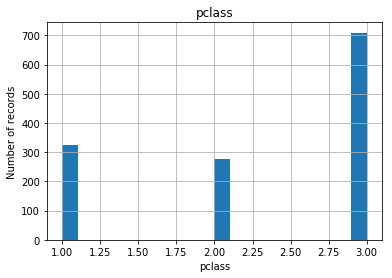

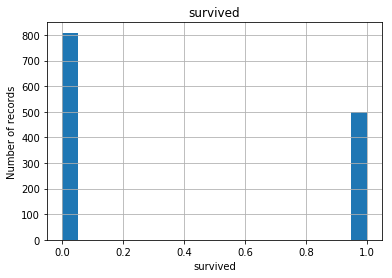

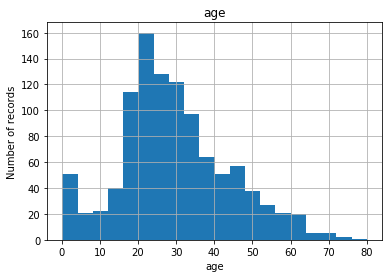

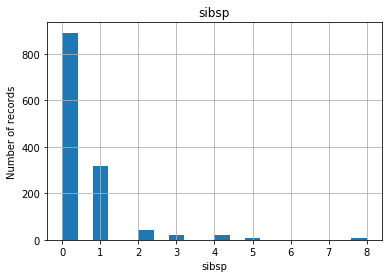

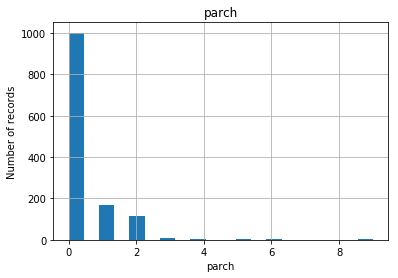

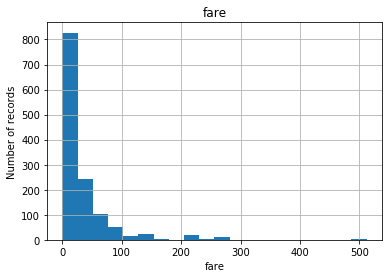

In [14]:
# Analyse the distributions of numercial variables
def distribution_numerical(df, var):
    df = df.copy()
    df[var].hist(bins=20)
    plt.ylabel('Number of records')
    plt.xlabel(var)
    plt.title(var)
    plt.show()
    
for var in vars_num:
    distribution_numerical(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [16]:
#check if values of cabin always begin with one letter

data['cabin'].value_counts()

F       8
C23     6
B57     5
G6      5
D       4
C78     4
F4      4
F33     4
C22     4
F2      4
B96     4
B58     3
E34     3
E101    3
C101    3
A34     3
B51     3
C86     2
C68     2
D28     2
C65     2
C123    2
B78     2
B71     2
E33     2
C124    2
C85     2
B28     2
D36     2
B35     2
       ..
D56     1
A32     1
B24     1
D45     1
C97     1
C39     1
A20     1
F38     1
C45     1
C90     1
E38     1
B30     1
B52     1
C128    1
B61     1
E45     1
D38     1
B86     1
E68     1
C132    1
B73     1
D6      1
C50     1
A11     1
D43     1
C105    1
E17     1
C51     1
B50     1
D7      1
Name: cabin, Length: 181, dtype: int64

In [18]:
#keep only first value of string (the letter) in X_test and X_train
X_train['cabin'] = [x[0] if isinstance(x, str) else np.nan for x in X_train['cabin']]
X_test['cabin'] = [x[0] if isinstance(x, str) else np.nan for x in X_test['cabin']]

In [19]:
#check if numbers were dropped

X_train.head(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr
44,1,female,41.0,0,0,134.5000,E,C,Miss
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss
574,2,male,29.0,1,0,21.0000,NaN,S,Mr


In [20]:
#check in test
X_test.head(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1139,3,male,38.0,0,0,7.8958,NaN,S,Mr
533,2,female,21.0,0,1,21.0000,NaN,S,Miss
459,2,male,42.0,1,0,27.0000,NaN,S,Mr
1150,3,male,NaN,0,0,14.5000,NaN,S,Mr
393,2,male,25.0,0,0,31.5000,NaN,S,Mr


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [21]:
# create new 0/1 column to indicate if row had missing value (1) or not (0)

for var in num_vars_with_missing:
    
    # train
    # create new binary columnn
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    
    # test
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)

In [22]:
#check if binary column was made 
X_train.head(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr,0
44,1,female,41.0,0,0,134.5000,E,C,Miss,0
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr,1
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss,0
574,2,male,29.0,1,0,21.0000,NaN,S,Mr,0


In [23]:
#age was only numerical column with missing value, replace missing values with median
#but 'fare' also had one!!!!!Did not show up earlier 
# in training set 
median_value= X_train['age'].median()

X_train['age']=X_train['age'].fillna(median_value)

# check that there are no more missing values in age
X_train['age'].isnull().sum()


0

In [24]:
median_value= X_test['age'].median()

X_test['age']=X_test['age'].fillna(median_value)

# check that there are no more missing values in age
X_test['age'].isnull().sum()


0

In [25]:
#also replace the one missing value in fare 
median_value= X_train['fare'].median()

X_train['fare']=X_train['fare'].fillna(median_value)

# check that there are no more missing values in age
X_train['fare'].isnull().sum()

0

In [26]:
#and replace in test set
median_value= X_test['fare'].median()

X_test['fare']=X_test['fare'].fillna(median_value)

# check that there are no more missing values in age
X_test['fare'].isnull().sum()

0

### Replace Missing data in categorical variables with the string **Missing**

In [27]:
# make list of categorical variables with missing values
vars_with_na = [var for var in X_train.columns if X_train[var].isnull().sum()>1 and X_train[var].dtypes=='O']

# print the variable name and the percentage of missing values
for var in vars_with_na:
    print(var, np.round(X_train[var].isnull().mean(), 3),  ' % missing values')


cabin 0.767  % missing values
embarked 0.002  % missing values


In [28]:
# function to replace NA in categorical variables
def fill_categorical_na(df, var_list):
    X = df.copy()
    X[var_list] = df[var_list].fillna('Missing')
    return X

In [29]:
# replace missing values with new label: "Missing"
X_train = fill_categorical_na(X_train, vars_with_na)
X_test = fill_categorical_na(X_test, vars_with_na)

# check that there are no missing values in train set
X_train[vars_with_na].isnull().sum()


cabin       0
embarked    0
dtype: int64

In [30]:
#check no missing values in test set
X_test[vars_with_na].isnull().sum()

cabin       0
embarked    0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [31]:
# what where the categorical variables again
vars_cat = [var for var in X_train.columns if X_train[var].dtype == 'O']
print(vars_cat)

['sex', 'cabin', 'embarked', 'title']


In [32]:
#which labels are present in only a small number of (less than 5%) the cases

def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)['sex'].count() / len(df)
    return tmp[tmp<rare_perc]

for var in vars_cat:
    print(analyse_rare_labels(data, var, 0.05))
    print()

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

Series([], Name: sex, dtype: float64)

cabin
A10     0.000764
A11     0.000764
A14     0.000764
A16     0.000764
A18     0.000764
A19     0.000764
A20     0.000764
A21     0.000764
A23     0.000764
A24     0.000764
A26     0.000764
A29     0.000764
A31     0.000764
A32     0.000764
A34     0.002292
A36     0.000764
A5      0.000764
A6      0.000764
A7      0.000764
A9      0.000764
B10     0.000764
B101    0.000764
B102    0.000764
B11     0.000764
B18     0.001528
B19     0.000764
B20     0.001528
B22     0.001528
B24     0.000764
B26     0.000764
          ...   
E17     0.000764
E24     0.001528
E25     0.001528
E31     0.001528
E33     0.001528
E34     0.002292
E36     0.000764
E38     0.000764
E39     0.000764
E40     0.000764
E44     0.001528
E45     0.000764
E46     0.001528
E49     0.000764
E50     0.001528
E52     0.000764
E58     0.000764
E60     0.000764
E63     0.000764
E67     0.001528
E68     0.000764
E77     0.000764
E8      0.001528
F       0.006112
F2      0.003056
F33

In [33]:
#rare labels in 'cabin' and 'title'. These will be recoded to 'Rare'

def find_frequent_labels(df, var, rare_perc):
    # finds the percentage of cases for the labels and recodes labels that occur in less than 5% of the cases
    df = df.copy()
    tmp = df.groupby(var)['sex'].count() / len(df)
    return tmp[tmp>rare_perc].index



In [34]:
for var in vars_cat:
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')


In [35]:
X_train.head(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na
1118,3,male,25.0,0,0,7.9250,Missing,S,Mr,0
44,1,female,41.0,0,0,134.5000,Rare,C,Miss,0
1072,3,male,28.0,0,0,7.7333,Missing,Q,Mr,1
1130,3,female,18.0,0,0,7.7750,Missing,S,Miss,0
574,2,male,29.0,1,0,21.0000,Missing,S,Mr,0


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [36]:
#create dummy variable, drop the first category
dummies=pd.get_dummies(X_train[['sex', 'cabin', 'embarked', 'title']], drop_first=True)

In [37]:
dummys=pd.get_dummies(X_test[['sex', 'cabin', 'embarked', 'title']], drop_first=True)

In [38]:
#append dummy variables to X_train
X_train=pd.concat([X_train, dummies], axis=1)

In [39]:
#append dummy variable to X_test
X_test=pd.concat([X_test, dummys], axis=1)

In [40]:
#check if dummies are appended
X_train.head(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,male,25.0,0,0,7.9250,Missing,S,Mr,0,1,1,0,0,0,1,1,0,0
44,1,female,41.0,0,0,134.5000,Rare,C,Miss,0,0,0,1,0,0,0,0,0,0
1072,3,male,28.0,0,0,7.7333,Missing,Q,Mr,1,1,1,0,1,0,0,1,0,0
1130,3,female,18.0,0,0,7.7750,Missing,S,Miss,0,0,1,0,0,0,1,0,0,0
574,2,male,29.0,1,0,21.0000,Missing,S,Mr,0,1,1,0,0,0,1,1,0,0


In [41]:
#check if dummies are appended
X_test.head(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare
1139,3,male,38.0,0,0,7.8958,Missing,S,Mr,0,1,1,0,0,1,1,0,0
533,2,female,21.0,0,1,21.0000,Missing,S,Miss,0,0,1,0,0,1,0,0,0
459,2,male,42.0,1,0,27.0000,Missing,S,Mr,0,1,1,0,0,1,1,0,0
1150,3,male,26.0,0,0,14.5000,Missing,S,Mr,1,1,1,0,0,1,1,0,0
393,2,male,25.0,0,0,31.5000,Missing,S,Mr,0,1,1,0,0,1,1,0,0


Column embarked_Rare is not in test set (so label does not exist in test set). So model will learn nothing, column will be dropped

In [42]:
#drop original columns in X_train
for columns in ['sex', 'cabin', 'embarked', 'title', 'embarked_Rare']:
    X_train.drop(columns, axis=1, inplace=True)    


In [43]:
#drop original columns in X_test
for columns in ['sex', 'cabin', 'embarked', 'title']:
    X_test.drop(columns, axis=1, inplace=True)    


### Scale the variables

- Use the standard scaler from Scikit-learn

In [44]:
X_train.head(2)

,pclass,age,sibsp,parch,fare,age_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.925,0,1,1,0,0,1,1,0,0
44,1,41.0,0,0,134.500,0,0,0,1,0,0,0,0,0


In [45]:
#Standardize the numercial features
X_train[['pclass','age', 'fare', 'sibsp', 'parch']] = StandardScaler().fit_transform(X_train[['pclass','age', 'fare', 'sibsp', 'parch']])
X_test[['pclass','age', 'fare', 'sibsp', 'parch']] = StandardScaler().fit_transform(X_test[['pclass','age', 'fare', 'sibsp', 'parch']])


/Users/nickrood/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nickrood/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/nickrood/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nickrood/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [46]:
X_train.head(3)

,pclass,age,sibsp,parch,fare,age_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare
1118,0.835808,-0.370162,-0.478911,-0.455423,-0.504782,0,1,1,0,0,1,1,0,0
44,-1.542157,0.904029,-0.478911,-0.455423,1.971555,0,0,0,1,0,0,0,0,0
1072,0.835808,-0.131251,-0.478911,-0.455423,-0.508533,1,1,1,0,1,0,1,0,0


In [47]:
X_test.head(3)

,pclass,age,sibsp,parch,fare,age_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare
1139,0.867071,0.668521,-0.506817,-0.409606,-0.436773,0,1,1,0,0,1,1,0,0
533,-0.347756,-0.526380,-0.506817,0.652936,-0.194311,0,0,1,0,0,1,0,0,0
459,-0.347756,0.949674,0.769972,-0.409606,-0.083295,0,1,1,0,0,1,1,0,0


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [48]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

lr=LogisticRegression(C=0.0005, random_state=0)

#train model using training set 
lr.fit(X_train,y_train)

/Users/nickrood/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0005, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
#make predictions on the test set 
y_pred = lr.predict(X_test)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [51]:
print(accuracy_score(y_test,y_pred))
print(roc_auc_score(y_test, y_pred))

0.7137404580152672
0.6288271604938271


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**